In [ ]:
import pandas as pd
from scipy.stats import poisson
import numpy as np
import seaborn as sns
import random
import datetime
import pickle

#### read data

Read our initial data with patients

In [ ]:
data = pd.read_csv('.../processed_ok_all_restore_ext.csv', on_bad_lines='skip',sep = ";", header= None)

In [ ]:
data.columns = ['index', 'adress', 'lat', 'lon', 'final']

In [ ]:
data

,index,adress,lat,lon,final
0,0,Пушкин Песочная 6 кв 12,59.729019,30.400148,ГБ №16
1,1,Будапештская 69 кор 2 кв 19,59.846138,30.386215,НИИ СП им. Джанелидзе
2,2,Петродворец Б Разведчика 14 кор 4 кв 38,59.876707,29.890929,ГБ №40
3,3,Солдата Корзуна 42 кв 73,59.831435,30.222416,НИИ СП им. Джанелидзе
4,4,"Стадион "" Петровский """,59.956949,30.276342,ГБ №1
...,...,...,...,...,...
5120,5120,"Курляндская ул., 32 - 81",59.911236,30.278570,ГБ №16
5121,5121,"Испытателей пр., 20 - 500",60.003745,30.292898,ГБ №2
5122,5122,"Олеко Дундича пр., 35-1",59.939095,30.315868,ГБ №26
5123,5123,"Академика Байкова ул., 17 - 1 - 125",60.026168,30.379316,ГБ №3


Leave the data within the city boundaries (without suburbs)

In [ ]:
data_filtered_lat = data[data['lat'] <= 60.05]

In [ ]:
data_filtered_lat = data_filtered_lat[data_filtered_lat['lat'] >= 59.8]

In [ ]:
 data_filtered = data_filtered_lat[data_filtered_lat['lon'] < 30.6]

In [ ]:
 data_filtered = data_filtered[data_filtered['lon'] >= 30.1]

In [ ]:
coordinates_filtered = data_filtered[['lat', 'lon']].to_numpy()

In [ ]:
len(coordinates_filtered)

3820

In [ ]:
coordinates_filtered

array([[59.846138, 30.386215],
       [59.831435, 30.222416],
       [59.956949, 30.276342],
       ...,
       [59.939095, 30.315868],
       [60.026168, 30.379316],
       [59.876323, 30.401244]])

Choose 4 hospitals for analysis

In [ ]:
hosp_1 = [59.849212, 30.295701] 
hosp_2 = [60.000713, 30.199033] 
hosp_3 = [60.036281, 30.360164] 
hosp_4 = [59.879137, 30.468124]

How it looks

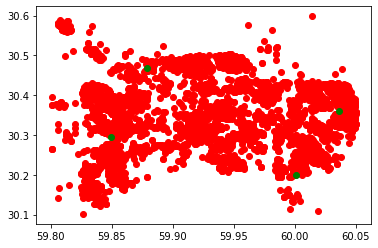

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(data_filtered.lat, data_filtered.lon, color="red") # plotting single point
plt.scatter(hosp_1[0], hosp_1[1], color = "green" )
plt.scatter(hosp_2[0], hosp_2[1], color = "green" )
plt.scatter(hosp_3[0], hosp_3[1], color = "green" )
plt.scatter(hosp_4[0], hosp_4[1], color = "green" )
plt.show()

To do the simulations we need to know the hour of the patient's call distribution

In [ ]:
data_hours = pd.read_csv('.../hours.csv', on_bad_lines='skip',sep = ",", header= 0)

In [ ]:
data_hours

,Unnamed: 0,Час
0,0,0.043853
1,1,0.030932
2,2,0.023101
3,3,0.020752
4,4,0.023493
5,5,0.019773
6,6,0.014879
7,7,0.027604
8,8,0.024863
9,9,0.043657


Make the probability of the time slots

In [ ]:
data_hours_first = sum(data_hours['Час'][7:10])

In [ ]:
data_hours_first

0.0961237274862959

In [ ]:
data_hours_second = sum(data_hours['Час'][10:17])

In [ ]:
data_hours_second

0.4089663273296785

In [ ]:
data_hours_third = sum(data_hours['Час'][17:20])

In [ ]:
data_hours_third

0.15133124510571638

In [ ]:
data_hours_fourth = sum(data_hours['Час'][20:]) + sum(data_hours['Час'][0:7])

In [ ]:
data_hours_fourth 


0.34357870007830804

In [ ]:
data_hours_fourth + data_hours_third + data_hours_second + data_hours_first

0.9999999999999989

In [ ]:
time_prob = [data_hours_first, data_hours_second, data_hours_third,  data_hours_fourth]

In [ ]:
time_prob

[0.0961237274862959,
 0.4089663273296785,
 0.15133124510571638,
 0.34357870007830804]

#### data distance 

Read the file with the gmaps distances over our patients

In [ ]:
data_distance = pd.read_csv('.../df_all_times_and_hospitals.csv')

The unit here is the coordinates of the patient, "one_hosp_first_time" means distance to the first hospital in the first time slot, "two_hosp_first_time" - to the second in the first time slot and so on

In [ ]:
data_distance

,Unnamed: 0,one_hosp_first_time,two_hosp_first_time,three_hosp_first_time,four_hosp_first_time,one_hosp_second_time,two_hosp_second_time,three_hosp_second_time,four_hosp_second_time,one_hosp_third_time,two_hosp_third_time,three_hosp_third_time,four_hosp_third_time,one_hosp_forth_time,two_hosp_fourth_time,three_hosp_fourth_time,four_hosp_fourth_time
0,0,0.201481,0.457222,0.498333,0.192037,0.201481,0.457222,0.498333,0.192037,0.201481,0.457222,0.498333,0.192037,0.201481,0.457222,0.498333,0.192037
1,1,0.158889,0.404815,0.583519,0.362222,0.158889,0.404815,0.570741,0.362222,0.158889,0.404815,0.570741,0.362222,0.158889,0.404815,0.583519,0.362222
2,2,0.265185,0.236111,0.363889,0.392593,0.265185,0.236111,0.363889,0.392593,0.265185,0.236111,0.363889,0.392593,0.265185,0.236111,0.363889,0.392593
3,3,0.321667,0.571852,0.388333,0.046481,0.321667,0.532037,0.388333,0.046481,0.321667,0.532037,0.388333,0.046481,0.321667,0.527778,0.388333,0.046481
4,4,0.431111,0.290926,0.194815,0.502407,0.431111,0.290926,0.194815,0.502407,0.431111,0.290926,0.194815,0.502407,0.431111,0.290926,0.194815,0.502407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3815,3815,0.222407,0.304630,0.544259,0.379259,0.202963,0.304630,0.483333,0.393148,0.202963,0.304630,0.483333,0.393148,0.222407,0.304630,0.483333,0.379259
3816,3816,0.349815,0.209630,0.228148,0.443704,0.349815,0.209630,0.228148,0.443704,0.349815,0.209630,0.228148,0.519259,0.349815,0.209630,0.228148,0.443704
3817,3817,0.355000,0.350741,0.393519,0.351667,0.355000,0.350741,0.393519,0.351667,0.355000,0.350741,0.393519,0.351667,0.355000,0.350741,0.386667,0.351667
3818,3818,0.492222,0.352037,0.071667,0.417037,0.492222,0.352037,0.071667,0.417037,0.507963,0.352037,0.071667,0.417037,0.492222,0.352037,0.071667,0.417037


#### Hospital model

Hospital model as in the prev simulations

In [ ]:
class Hospital:
  def __init__(self, N_lim, servers, location, strategy, processing_speed):
    self.N_lim = N_lim
    self.servers = servers
    self.location = location
    self.strategy = strategy
    self.queue = 0
    self.total_patients = 0
    self.total_time = 0
    self.processing_speed = processing_speed
  def accept(self):
    if self.strategy == 'A':
      return True
    elif self.queue < self.N_lim:
      return True
    else:
      return False
  def sent_patient(self, time_real):
    self.queue += 1
    self.total_patients +=1 
    self.total_time += time_real*10
    self.total_time += self.queue/ (self.servers*self.processing_speed)
  def next_round(self):
    self.queue -= self.servers*self.processing_speed
    self.queue = max(0, self.queue)
  def utility_simple(self): #utility
    if self.total_patients > 0:
      return self.total_patients/ self.total_time
    else:
      return 0 
  def p_m(self, t):
      return (0.000043 * t ** 2 + 0.0045 * t)/1000
  def utility_M1Y(self,  r = 1, e = 0, penalty = 0.01):
    # more complicated function
    if self.total_patients > 0:
      return self.total_patients*((1-self.p_m(self.total_time))*r - e) - (self.total_patients- self.total_patients*(1-self.p_m(self.total_time)))*penalty
    else:
      return 0
  def utility_high_M1Y(self,  r = 1, e = 0, penalty = 0.1):
  # more complicated function
    if self.total_patients > 0:
      return self.total_patients*((1-self.p_m(self.total_time))*r - e) - (self.total_patients- self.total_patients*(1-self.p_m(self.total_time)))*penalty
    else:
      return 0
  def utility_very_high_M1Y(self,  r = 1, e = 0, penalty = 0.25):
  # more complicated function
    if self.total_patients > 0:
      return self.total_patients*((1-self.p_m(self.total_time))*r - e) - (self.total_patients- self.total_patients*(1-self.p_m(self.total_time)))*penalty
    else:
      return 0
  def surv_number(self):
    return (self.total_patients*(1-self.p_m(self.total_time/num_roundes)))
  def utility_M1Y_middle_reward(self,  r = 1.5, e = 0, penalty = 0.01):
    # more complicated function
    if self.total_patients > 0:
      return self.total_patients*((1-self.p_m(self.total_time))*r - e) - (self.total_patients- self.total_patients*(1-self.p_m(self.total_time)))*penalty
    else:
      return 0
  def utility_function_punish_everyone(self, r = 1, e = 0, penalty = 0.1): 
      return self.total_patients**((1-self.p_m(self.total_time))*r - e) - np.sum((self.total_patients- self.total_patients*(1-self.p_m(self.total_time)))*penalty)

In [ ]:
num_roundes = 1000

Here the function that chooses time slot using the corresponding probabilities

In [ ]:
def time_patient(): 
    return np.random.choice(np.arange(0, 4), p= time_prob) # 0,1,2,3 

In [ ]:
def round_simulation_notnormalized(num_rounds, l, strategy, generate_patient, num_servers, mu, utility, hospital_location):
  total_patients = 0
  # utility: maps hospital to number
  h1 = Hospital(1, num_servers[0], hospital_location[0], strategy[0], mu) # 8 
  h2 = Hospital(1, num_servers[1], hospital_location[1], strategy[1], mu) 
  h3 = Hospital(1, num_servers[2], hospital_location[2], strategy[2], mu)
  h4 = Hospital(1, num_servers[3], hospital_location[3], strategy[3], mu)
  for i in range(num_rounds):
    num_patients = poisson.rvs(mu=l, size=1)[0] # poisson with parameter l
    total_patients += num_patients
    for j in range(num_patients):
      index_patient = np.random.choice(np.arange(0, 3820)) #3820 - len of dataframe
      time = time_patient()
      if time == 0:
              all_hospitals = [(h1, data_distance['one_hosp_first_time'][index_patient]),
                       (h2, data_distance['two_hosp_first_time'][index_patient]),
                       (h3, data_distance['three_hosp_first_time'][index_patient]),
                       (h4, data_distance['four_hosp_first_time'][index_patient])]
      elif time == 1:
         
         all_hospitals = [(h1, data_distance['one_hosp_second_time'][index_patient]),
                       (h2, data_distance['two_hosp_second_time'][index_patient]),
                       (h3, data_distance['three_hosp_second_time'][index_patient]),
                       (h4, data_distance['four_hosp_second_time'][index_patient])]
      elif time == 2:
         
         all_hospitals = [(h1, data_distance['one_hosp_third_time'][index_patient]),
                       (h2, data_distance['two_hosp_third_time'][index_patient]),
                       (h3, data_distance['three_hosp_third_time'][index_patient]),
                       (h4, data_distance['four_hosp_third_time'][index_patient])]
      elif time == 3:
         
         all_hospitals = [(h1, data_distance['one_hosp_forth_time'][index_patient]),
                       (h2, data_distance['two_hosp_fourth_time'][index_patient]),
                       (h3, data_distance['three_hosp_fourth_time'][index_patient]),
                       (h4, data_distance['four_hosp_fourth_time'][index_patient])]
      
      #patient = generate_patient()
      #all_hospitals = [(h1, gmaps_distance(patient, h1.location)),
      #                 (h2, gmaps_distance(patient, h2.location)),
      #                 (h3, gmaps_distance(patient, h3.location)),
      #                 (h4, gmaps_distance(patient, h4.location))]
      all_hospitals_sorted = sorted(all_hospitals, key = lambda variable: variable[1])
      found_hospitals = False
      for h in all_hospitals_sorted:
        if h[0].accept():
          h[0].sent_patient(h[1])
          found_hospitals = True
          break
      if not found_hospitals:
        all_hospitals_sorted[0][0].sent_patient(all_hospitals_sorted[0][1])
    h1.next_round()
    h2.next_round()
    h3.next_round()
    h4.next_round()
  return [[utility(h1), utility(h2), utility(h3), utility(h4)], (h1.surv_number() + h2.surv_number() + h3.surv_number() + h4.surv_number())/total_patients, (h1.total_time + h2.total_time + h3.total_time + h4.total_time)/total_patients]

In [ ]:
def is_equilibrium(matrix, strategies):
  num_players = len(strategies)
  for i in range (0, num_players):
    current_utility = matrix[tuple(strategies)][i]
    #print(current_utility)
    alt_strats = np.array(strategies)
    for j in range(0, matrix.shape[i]):
      alt_strats[i] = j
      if matrix[tuple(alt_strats)][i] > current_utility:
        return False
  return True

In [ ]:
num_roundes = 1000
num_patients = 3
num_servers = 4

In [ ]:
def generate_matrix_gmaps(num_roundes, num_patients, num_servers, mu, generate_patient_function, utility, hospital_location):
  matrix = np.array([[[[round_simulation_notnormalized(num_roundes,num_patients, 'AAAA', generate_patient_function, num_servers, mu, utility, hospital_location )[0], round_simulation_notnormalized(num_roundes,num_patients, 'AAAR', generate_patient_function, num_servers, mu , utility, hospital_location)[0]], [round_simulation_notnormalized(num_roundes,num_patients, 'AARA', generate_patient_function, num_servers, mu, utility, hospital_location )[0], round_simulation_notnormalized(num_roundes,num_patients, 'AARR', generate_patient_function, num_servers, mu, utility, hospital_location )[0]]],
                            [[round_simulation_notnormalized(num_roundes,num_patients, 'ARAA', generate_patient_function, num_servers, mu, utility, hospital_location )[0], round_simulation_notnormalized(num_roundes,num_patients, 'ARAR', generate_patient_function, num_servers, mu , utility, hospital_location)[0]], [round_simulation_notnormalized(num_roundes,num_patients, 'ARRA', generate_patient_function, num_servers, mu, utility, hospital_location )[0], round_simulation_notnormalized(num_roundes,num_patients, 'ARRR', generate_patient_function, num_servers, mu, utility, hospital_location )[0]]]],
                           [[[round_simulation_notnormalized(num_roundes,num_patients, 'RAAA', generate_patient_function, num_servers, mu, utility, hospital_location )[0], round_simulation_notnormalized(num_roundes,num_patients,  'RAAR', generate_patient_function, num_servers, mu, utility, hospital_location )[0]], [round_simulation_notnormalized(num_roundes,num_patients, 'RARA', generate_patient_function, num_servers, mu, utility, hospital_location )[0], round_simulation_notnormalized(num_roundes,num_patients, 'RARR', generate_patient_function, num_servers, mu, utility, hospital_location )[0]]],
                            [[round_simulation_notnormalized(num_roundes,num_patients, 'RRAA', generate_patient_function, num_servers, mu, utility, hospital_location )[0], round_simulation_notnormalized(num_roundes,num_patients,  'RRAR', generate_patient_function, num_servers, mu, utility, hospital_location )[0]], [round_simulation_notnormalized(num_roundes,num_patients, 'RRRA', generate_patient_function, num_servers, mu, utility, hospital_location )[0], round_simulation_notnormalized(num_roundes,num_patients, 'RRRR', generate_patient_function, num_servers, mu, utility, hospital_location )[0]]]]])
  return matrix


In [ ]:
def number_to_letter(numbers):
  s = ''
  for i in numbers:
    if i == 0:
      s += 'A'
    else:
      s += 'R'
  return s

In [ ]:
def generate_real_patient_simple_filtered():
  rng = np.random.default_rng()
  one_hospital = rng.choice(coordinates_filtered, 1)
  return one_hospital[0]

### Experiments

#### Experiments, base utility

In [ ]:
def find_solution_filtered(l, mu, n, hospital_location):
    G = generate_matrix_gmaps(num_roundes , l, n, mu,generate_real_patient_simple_filtered, lambda hospital : hospital.utility_simple(), hospital_location )
    for first_h in [0,1]:
      for second_h in [0,1]:
        for third_h in [0,1]:
          for forth_h in [0,1]:
            if is_equilibrium(G, [first_h, second_h, third_h, forth_h]) == True: # g has an equilibrium
                return number_to_letter([first_h, second_h, third_h, forth_h])
    return 'Inconsistent'

In [ ]:
hue_order = ['AAAA', 'AAAR', 'AARA', 'ARAA', 'RAAA', 'ARAR', 'RARA', 'RAAR', 'ARRA', 'RRAA', 'AARR', 'ARRR', 'RARR', 'RRAR', 'RRRA','RRRR','Inconsistent']

In [ ]:
palette = sns.color_palette("coolwarm", n_colors=17)

In [ ]:
def solution_plot_filtered(n, ax=None, legend=False,hospital_location = [hosp_1,hosp_2,hosp_3,hosp_4]):
    data = {
        'Lambda': [],
        'Mu': [],
        'Nash Equilibrium': []
    }
    for l in np.linspace(0.5, 2, 50):
        for mu in np.linspace(0.5, 2, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Nash Equilibrium'].append(find_solution_filtered(l, mu, n, hospital_location))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Nash Equilibrium', data=data, ax=ax,hue_order=hue_order, legend=legend, s=100, palette=palette).set(title='Initial Solution Plot, distances are calsulated via gmaps')
    if ax is not None:
        ax.set_title('N = ' + str(n))

In [ ]:
num_roundes = 1000
num_patients = 3
num_servers = 4

In [ ]:
num_roundes = 1000

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


Wall time: 1h 46min 28s


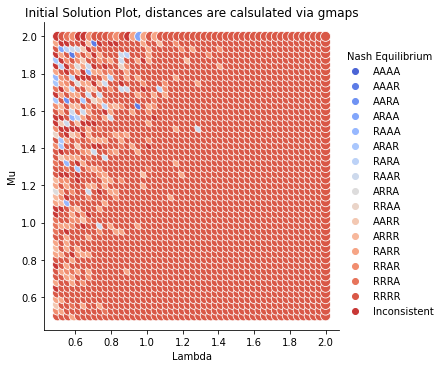

In [ ]:
%%time
solution_plot_filtered([1,1,1,1], legend='brief') 

#### Experiments, p4p utility

In [ ]:
def find_solution_filtered_m1y(l, mu, n, hospital_location):
    G = generate_matrix_gmaps(num_roundes , l, n, mu,generate_real_patient_simple_filtered, lambda hospital: hospital.utility_M1Y(), hospital_location)
    for first_h in [0,1]:
      for second_h in [0,1]:
        for third_h in [0,1]:
          for forth_h in [0,1]:
            if is_equilibrium(G, [first_h, second_h, third_h, forth_h]) == True: # g has an equilibrium
                return number_to_letter([first_h, second_h, third_h, forth_h])
    return 'Inconsistent'

In [ ]:
def solution_plot_filtered_m1y(n, ax=None, legend=False, hospital_location = [hosp_1,hosp_2,hosp_3,hosp_4]):
    data = {
        'Lambda': [],
        'Mu': [],
        'Nash Equilibrium': []
    }
    for l in np.linspace(0.5, 2, 50):
        for mu in np.linspace(0.5, 2, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Nash Equilibrium'].append(find_solution_filtered_m1y(l, mu, n, hospital_location))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Nash Equilibrium', data=data, ax=ax,hue_order=hue_order, legend=legend, s=100, palette=palette).set(title='Solution Plot with Financial Model, distances are calsulated via gmaps')
    if ax is not None:
        ax.set_title('N = ' + str(n))

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


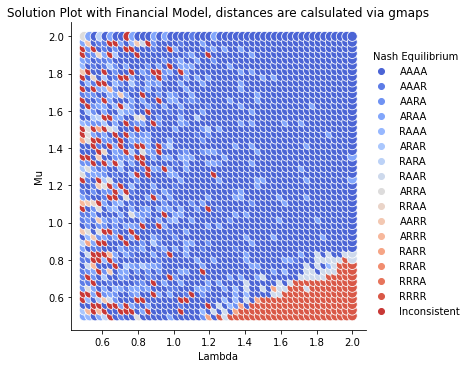

In [ ]:
solution_plot_filtered_m1y([1,1,1,1], legend='brief') 

In [ ]:
def find_solution_filtered_high_m1y(l, mu, n, hospital_location):
    G = generate_matrix_gmaps(num_roundes , l, n, mu,generate_real_patient_simple_filtered, lambda hospital: hospital.utility_high_M1Y(), hospital_location)
    for first_h in [0,1]:
      for second_h in [0,1]:
        for third_h in [0,1]:
          for forth_h in [0,1]:
            if is_equilibrium(G, [first_h, second_h, third_h, forth_h]) == True: # g has an equilibrium
                return number_to_letter([first_h, second_h, third_h, forth_h])
    return 'Inconsistent'

In [ ]:
def solution_plot_filtered_high_m1y(n, ax=None, legend=False, hospital_location = [hosp_1,hosp_2,hosp_3,hosp_4]):
    data = {
        'Lambda': [],
        'Mu': [],
        'Nash Equilibrium': []
    }
    for l in np.linspace(0.5, 2, 50):
        for mu in np.linspace(0.5, 2, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Nash Equilibrium'].append(find_solution_filtered_high_m1y(l, mu, n, hospital_location))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Nash Equilibrium', data=data, ax=ax,hue_order=hue_order, legend=legend, s=100, palette=palette).set(title='Solution Plot with Financial Model, high fee, distances are calsulated via gmaps')
    if ax is not None:
        ax.set_title('N = ' + str(n))

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


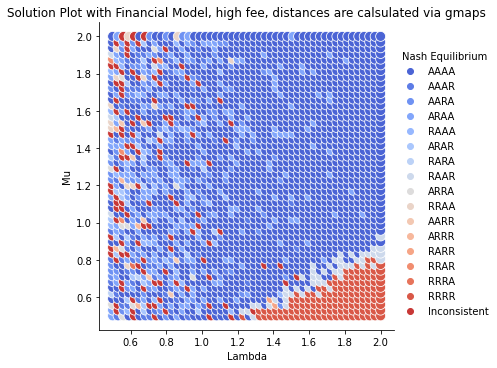

In [ ]:
solution_plot_filtered_high_m1y([1,1,1,1], legend='brief')

#### Experiments, mp4p utility

In [ ]:
def find_solution_filtered_punish_everyone(l, mu, n, hospital_location):
    G = generate_matrix_gmaps(num_roundes , l, n, mu,generate_real_patient_simple_filtered, lambda hospital: hospital.utility_function_punish_everyone(), hospital_location)
    for first_h in [0,1]:
      for second_h in [0,1]:
        for third_h in [0,1]:
          for forth_h in [0,1]:
            if is_equilibrium(G, [first_h, second_h, third_h, forth_h]) == True: # g has an equilibrium
                return number_to_letter([first_h, second_h, third_h, forth_h])
    return 'Inconsistent'

In [ ]:
def solution_plot_filtered_punish_everyone(n, ax=None, legend=False, hospital_location = [hosp_1,hosp_2,hosp_3,hosp_4]):
    data = {
        'Lambda': [],
        'Mu': [],
        'Nash Equilibrium': []
    }
    for l in np.linspace(0.5, 2, 50):
        for mu in np.linspace(0.5, 2, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Nash Equilibrium'].append(find_solution_filtered_punish_everyone(l, mu, n, hospital_location))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Nash Equilibrium', data=data, ax=ax,hue_order=hue_order, legend=legend, s=100, palette=palette).set(title='Solution Plot with Financial Model, punish all, distances are calsulated via gmaps')
    if ax is not None:
        ax.set_title('N = ' + str(n))


c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


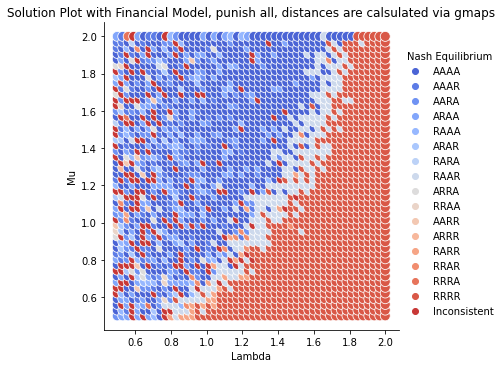

In [ ]:
solution_plot_filtered_punish_everyone([1,1,1,1], legend='brief') 

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


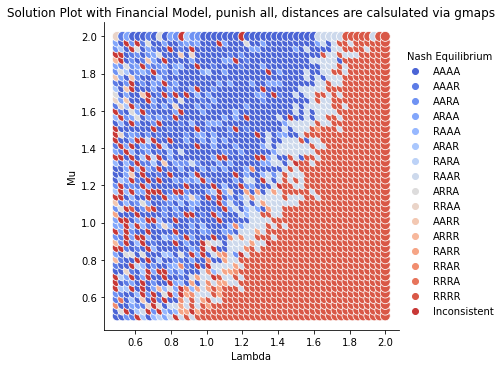

In [ ]:
solution_plot_filtered_punish_everyone([1,1,1,1], legend='brief') #n lim 1 pen 0.25

#### Experiments, different set of servers

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


Wall time: 1h 38min 39s


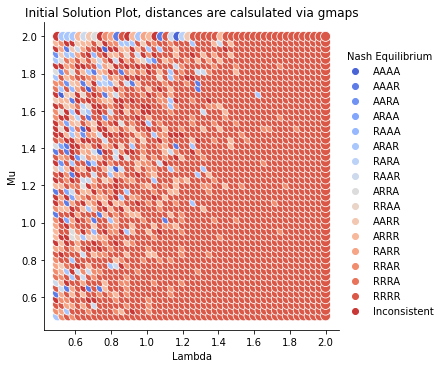

In [ ]:
%%time
solution_plot_filtered([3,1,3,1], legend='brief') #n lim 1

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


Wall time: 1h 56min 24s


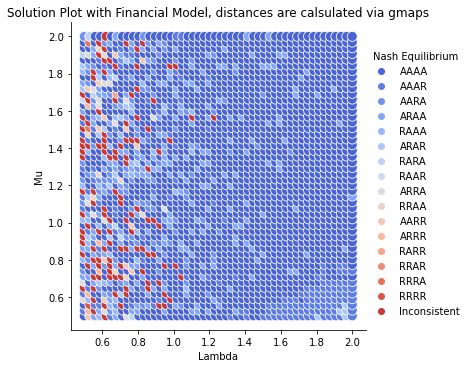

In [ ]:
%%time
solution_plot_filtered_m1y([3,1,3,1], legend='brief') #n lim 1

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


Wall time: 2h 17min 46s


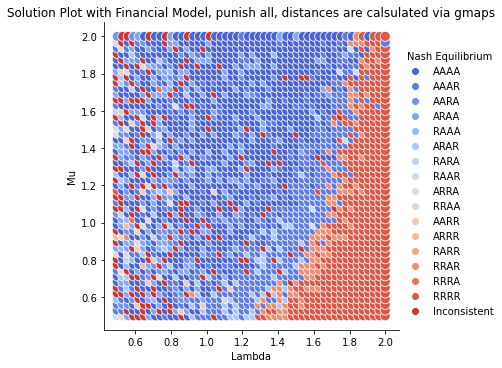

In [ ]:
%%time
solution_plot_filtered_punish_everyone([3,1,3,1], legend='brief') #n lim 1 pen 0.01

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


Wall time: 1h 25min 35s


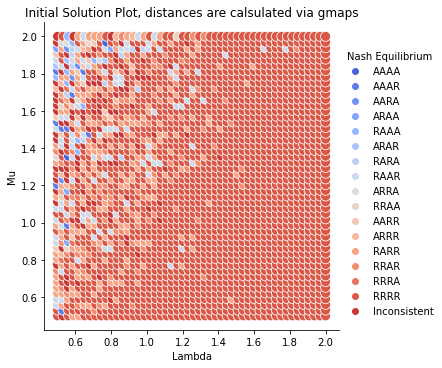

In [ ]:
%%time
solution_plot_filtered([1,2,2,1], legend='brief') #n lim 1

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


Wall time: 1h 26min


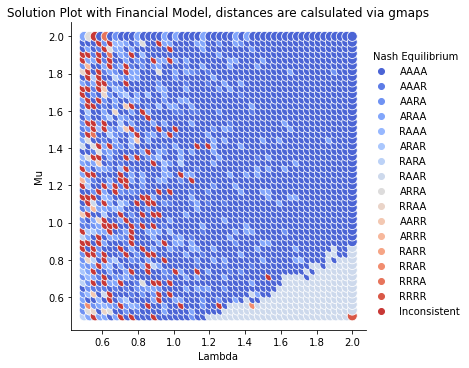

In [ ]:
%%time
solution_plot_filtered_m1y([1,2,2,1], legend='brief')#n lim 1

c:\Users\79520\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


Wall time: 1h 21min 40s


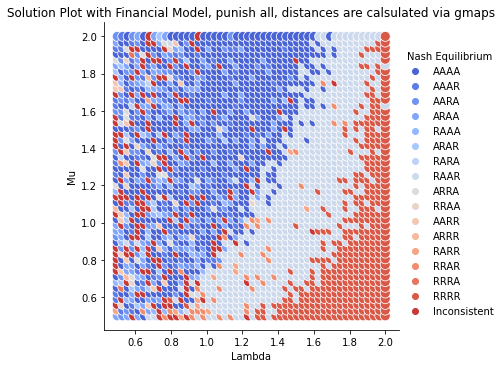

In [ ]:
%%time
solution_plot_filtered_punish_everyone([1,2,2,1], legend='brief')#n lim 1 pen 0.01

#### Experiments, metric's plots

In [ ]:
def global_plot_survival(num_servers, ax, mu=1, N_lim=5, t_c=10, hospital_location = [hosp_1,hosp_2,hosp_3,hosp_4] ):
    data = {
        'Patients Inflow': [],
        'Survival rate': [],
        'Strategy': []
    }
    l_space = np.linspace(0.5, 2, 50)
    desired_strategies = ['AAAA', 'RAAA', 'RRAA', 'ARRR','RRRR']
    for l in l_space:
        for strat in desired_strategies:
            data['Patients Inflow'].append(l)
            data['Survival rate'].append(round_simulation_notnormalized(num_roundes, l, strat, generate_real_patient_simple_filtered,num_servers, mu,lambda hospital : hospital.utility_M1Y_middle_reward(), hospital_location)[1])
            data['Strategy'].append(strat)

        
        
    data = pd.DataFrame(data)
    sns.lineplot(x="Patients Inflow", y="Survival rate", hue="Strategy", data=data, ax=ax)
    ax.ticklabel_format(useOffset=False, style='plain', axis='y')
    ax.set_title('Server N = ' + str(num_servers))

Wall time: 1min 51s


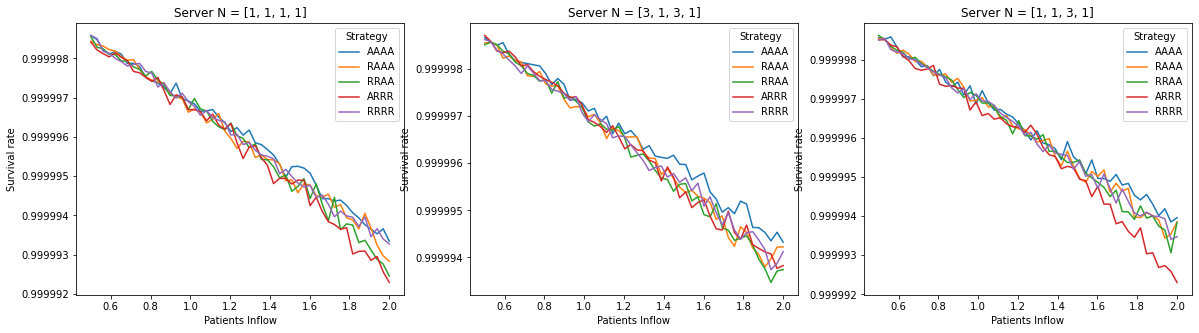

In [94]:
%%time
N_lim= 1
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
global_plot_survival([1,1,1,1], axs[0], mu=1.5, N_lim=N_lim)
global_plot_survival([3,1,3,1], axs[1], mu=1.5, N_lim=N_lim)
global_plot_survival([1,1,3,1], axs[2], mu=1.5, N_lim=N_lim)

In [44]:
def global_plot_time(num_servers, ax, mu=1, N_lim=5, t_c=10, hospital_location = [hosp_1,hosp_2,hosp_3,hosp_4] ):
    data = {
        'Patients Inflow': [],
        'Global time': [],
        'Strategy': []
    }
    l_space = np.linspace(1, 2, 50)
    desired_strategies = ['AAAA', 'RAAA', 'RRAA', 'ARRR', 'RRRR']
    for l in l_space:
        for strat in desired_strategies:
            data['Patients Inflow'].append(l)
            data['Global time'].append(round_simulation_notnormalized(num_roundes, l, strat, generate_real_patient_simple_filtered,num_servers, mu,lambda hospital : hospital.utility_simple(), hospital_location)[2])
            data['Strategy'].append(strat)

        
        
    data = pd.DataFrame(data)
    sns.lineplot(x="Patients Inflow", y="Global time", hue="Strategy", data=data, ax=ax)
    ax.set_title('Server N = ' + str(num_servers))

Wall time: 1min 46s


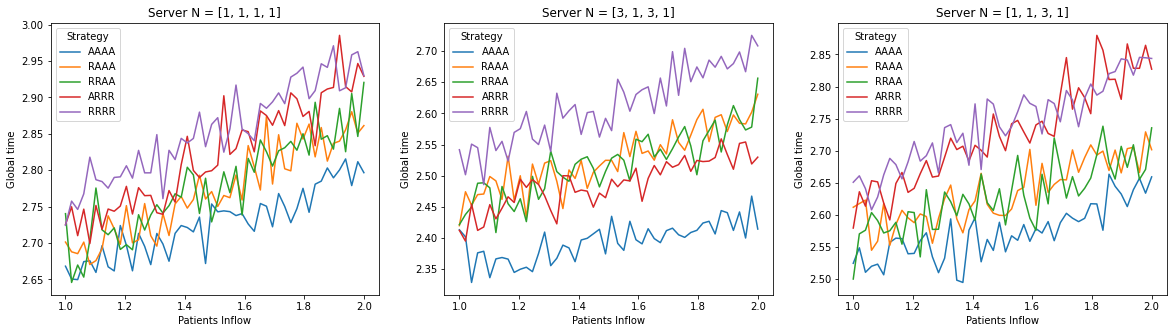

In [105]:
%%time
N_lim= 1
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
global_plot_time([1,1,1,1], axs[0], mu=1.5, N_lim=N_lim)
global_plot_time([3,1,3,1], axs[1], mu=1.5, N_lim=N_lim)
global_plot_time([1,1,3,1], axs[2], mu=1.5, N_lim=N_lim)